# Processing of Data from 2018-06-18
## Experiment 4

In [1]:
import os
import sys
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial as spa
import scipy.optimize as spo
import trackpy as tp
import pims

import support as sp

from tqdm import tqdm_notebook

from pims import pipeline
@pipeline
def as_gray(frame):
    red = frame[:, :, 0]
    green = frame[:, :, 1]
    blue = frame[:, :, 2]
    return 0.2125 * red + 0.7154 * green + 0.0721 * blue

%matplotlib inline

idx = pd.IndexSlice

The `_trackpy.dat` files where calculated using:

    directory = "Z:/LargeData/2018-06-18-Data/Experiment4/"
    base_names = sp.get_names(directory,ext='avi')

    errors4 = []

    for name in tqdm_notebook(base_names[48:]):
        try:
            video = pims.Video(name+'.avi')
            print(name)
            NumberOfFrames=video.get_metadata()["nframes"]
            f = tp.batch(as_gray(video[:]), 19, invert=False, threshold = 7, characterize = False, engine='numba')
            trj = tp.link(f, 10)
            new_name = os.path.join(os.path.split(name)[0],"ProcessedData",os.path.split(name)[1])+'_trackpy.dat'
            trj.filter(["particle","frame","x","y"]).to_csv(name+'_trackpy.dat',sep="\t")
        except Exception as e:
            number = [i for i,n in enumerate(base_names) if name==n][0]
            errors4.append([number,name,e])

This process took a little over three days, and therefore I would advise to repeat it at your own risk. There were five errors reported: files 47, 49, 50, 51, and 98 were not processed correctly.

The resulting trajectories however, contain some missing frames. These can be adjusted in the future from the videos, but for now, we can also ignore these points in the trajectories by allowing the linking algorithm to have a memory, as shown below. 

The following cell is expected to require around 5 hours to finish. 

In [59]:
directory = "C:/Users/aortiza/Desktop/Experiment4/"
base_names = sp.get_names(directory,ext='.dat')

base_names = [
    names[:names.find('trackpy')-1] for names in base_names if (names.find('trackpy')>0) & (names.find('ProcessedData')<0)]

In [5]:
for name in base_names:
    trj = pd.read_csv(name+"_trackpy.dat",sep="\t")
    find = trj.filter(["frame","x","y"])
    trj = tp.link(find, 10, memory = 5)

    trj = trj.set_index(["frame","particle"]).filter(["x","y"])
    trj_len = trj.groupby("particle").count()
    trj = trj.loc[idx[:,trj_len[trj_len["x"]>1000].index],:]
    
    new_name = os.path.join(os.path.split(name)[0],"ProcessedData",os.path.split(name)[1])+'_trackpy_mem.dat'
    trj.to_csv(new_name,sep="\t")

Frame 35999: 48 trajectories present.


In the end it took about 3 hours

# Process trayectory to include real time, and field. 

In [69]:
directory = "C:/Users/aortiza/Desktop/Experiment4/ProcessedData/"
base_names = sp.get_names(directory,ext='.dat')

In [71]:
def new_name(name):
    return os.path.join(os.path.split(name)[0],"ProcessedData",os.path.split(name)[1])+'_trackpy_mem.dat'

def from_frame_to_real_time(trj,name):
    """ Asigns labview timestamp to the frames of trj"""
    trj_real_time = pd.read_csv(name+'.dat',sep="\t",header=None)
    time = pd.to_datetime(trj_real_time[0].values+2*3600, unit="s", origin=pd.Timestamp('1904-01-01'))

    trj["time"] = time[trj.index.get_level_values("frame")]
    trj["id"] = trj.index.get_level_values("particle")
    trj = trj.set_index(["time","id"])
    return trj

def from_px_to_um(trj,px_size):
    trj.x = trj.x*px_size # microns per pixel
    trj.y = trj.y*px_size # microns per pixel
    return trj

def add_layers(trj):
    time = trj.index.get_level_values("time").unique()
    layer_indexes = sp.layers(trj.loc[sp.idx[time[round(len(time)/2)],:],:])
    
    for i,l in enumerate(layer_indexes):
        trj.loc[sp.idx[:,layer_indexes[i]],"layer"] = i
        
    return trj

def recenter(trj):
    center = sp.get_center(trj[trj.layer==0])
    trj.x+=-center[0]
    trj.y+=-center[1]
    return trj

field_filename = "Z:/LargeData/2018-06-18-Data/Field-2018-06-18.log"

field= pd.read_csv(field_filename,delim_whitespace=True)
field["time"] = pd.to_datetime(field["Time(s)"]+2*3600, unit="s", origin=pd.Timestamp('1904-01-01'))
field = field.set_index("time").filter(["X_Amplitude"])
    
def field_values(trj,field):

    time = trj.index.get_level_values("time").unique()
    
    field_re = field.reindex(field.index.append(time).sort_values(),method = "pad")
    field_re = field_re[~field_re.index.duplicated(keep='first')]
    field_re = field_re.loc[trj.index.get_level_values("time")[:]].X_Amplitude
    
    trj["field"] = field_re.values
    return trj

In [82]:
errors = []

for experiment,name in tqdm_notebook(enumerate(base_names[:])):
    try:
        trj = pd.read_csv(name+'.dat',sep="\t",index_col=["frame","particle"])
        trj = from_frame_to_real_time(trj,name.replace("_trackpy_mem","").replace("ProcessedData/",""))
        trj = from_px_to_um(trj,0.1805)
        trj = add_layers(trj)
        trj = recenter(trj)
        trj = field_values(trj,field)

        hdf_name = name.replace("_trackpy_mem","")+'_field_layer.hd5'

        with pd.HDFStore(hdf_name) as hdf_trj:
            hdf_trj.put('trj',trj,format='t')
            
            trj = sp.calculate_polar(trj)
            trj = sp.calculate_velocities(trj)

            omegas = trj.groupby(["field","layer"]).mean().filter(["omega"])
            omegas["experiment"] = experiment

            if trj.groupby('field').mean().sort_index().rel_time.diff().mean()>0:
                omegas["direction"] = "forward"
            else:
                omegas["direction"] = "backward"

            hdf_trj.put("omegas",omegas,format='t')
            
    except Exception as e:
        number = [i for i,n in enumerate(base_names) if name==n][0]
        errors.append([number,name,e])
        print([number, name, e])

A Jupyter Widget

C:\ProgramFiles\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


[57, 'C:/Users/aortiza/Desktop/Experiment4/ProcessedData/Depinning_2018_06_21_20_03_54_trackpy_mem', QhullError('QH6214 qhull input error: not enough points(2) to construct initial simplex (need 4)\n\nWhile executing:  | qhull d Qz Qc Qt Q12 Qbb\nOptions selected for Qhull 2015.2.r 2016/01/18:\n  run-id 1893000318  delaunay  Qz-infinity-point  Qcoplanar-keep  Qtriangulate\n  Q12-no-wide-dup  Qbbound-last  _pre-merge  _zero-centrum  Qinterior-keep\n',)]



In [83]:
directory = "C:/Users/aortiza/Desktop/Experiment4/ProcessedData/"
base_names = sp.get_names(directory,ext='.hd5')

In [84]:
def load_omegas(name):
    with pd.HDFStore(name+'.hd5') as hdf_trj:
        return hdf_trj.select('omegas')
results = pd.concat([load_omegas(name) for name in tqdm_notebook(base_names)])

A Jupyter Widget

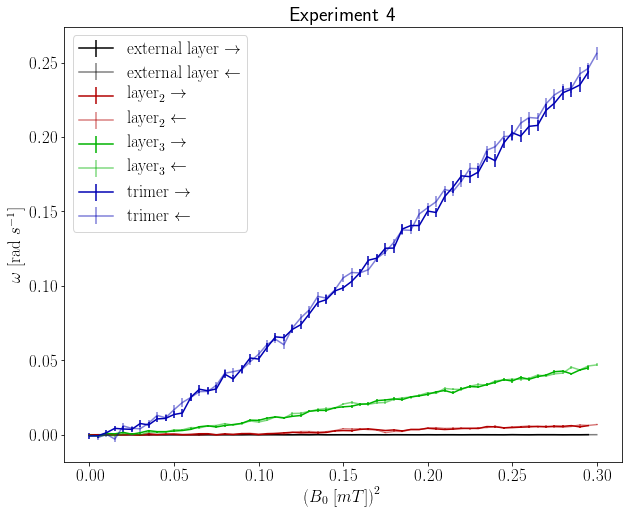

In [88]:
results_stat = results.groupby(["direction","field","layer"]).mean().filter(["omega"])
results_stat['error'] = results.groupby(["direction","field","layer"]).std().filter(["omega"])/\
                            np.sqrt(results.groupby(["direction","field","layer"]).count().filter(["omega"]))
results_stat.head()

fig, ax = plt.subplots(1,1,figsize=[10,8])

colors = [[0,0,0],[0.7,0,0],[0,0.7,0],[0,0,0.7]]

for i in np.arange(4):

    plt.errorbar(
        (results_stat.loc[sp.idx["forward",:,i],:].index.get_level_values("field")*1.5)**2,
        -results_stat.loc[sp.idx["forward",:,i],:].omega,
        results_stat.loc[sp.idx["forward",:,i],:].error,
        color=colors[i])
    plt.errorbar(
        (results_stat.loc[sp.idx["backward",:,i],:].index.get_level_values("field")*1.5)**2,
        -results_stat.loc[sp.idx["backward",:,i],:].omega,
        results_stat.loc[sp.idx["backward",:,i],:].error,
        color=colors[i],alpha=0.5)


font_size = 17
plt.rc('text', usetex=True)
plt.rc('font', size=font_size)

plt.title(r"Experiment 4")
plt.ylabel(r"$\omega\ [\textrm{rad}\ s^{-1}]$",fontsize=font_size)
plt.xlabel(r"$\left(B_0\ [mT]\right)^2$",fontsize=font_size)

plt.legend((
    r'$\textrm{external layer} \rightarrow$',
    r'$\textrm{external layer} \leftarrow$',
    r'$\textrm{layer}_2 \rightarrow$',
    r'$\textrm{layer}_2 \leftarrow$',
    r'$\textrm{layer}_3 \rightarrow$',
    r'$\textrm{layer}_3 \leftarrow$',
    r'$\textrm{trimer} \rightarrow$',
    r'$\textrm{trimer} \leftarrow$'),fontsize=font_size)